In [4]:
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import time as tm
from utils import *
import logging
logging.disable(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Data
data_path = '/Users/gpret/Desktop/MEDICINA/TVB_Distribution/demo_scripts/myScripts/For_OHBM/For_OHBM/tutorial_data'

In [20]:
con = connectivity.Connectivity.from_file()
con.tract_lengths = np.zeros((con.tract_lengths.shape))             # no time-delays
con.weights[np.diag_indices(con.weights.shape[0])] = 0 #mette a zero i weights degli indici diagonali, che sono quelli di una
#area con se stessa
# con.weights = np.log(con.weights+1)
con.weights /= con.weights.max() # a /= b equivale a fare a = a/b
con.configure()
nb_regions = con.number_of_regions
roi = con.region_labels

## Simulation with stimulus

In [56]:
x0ez=-2.1
x0pz=-2.12
x0num=-2.4

#Here I set the x0 emulating a temporal sclerosis, which is worse in in the anterior right hippocampus but also made 
#damage to nearby areas, as showed in common MRI findings (https://radiopaedia.org/articles/1664)
EZ = ['rTCC']
PZ = ['rTCI', 'rTCPOL', 'rTCS']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.02

Stimuli applied from the SEEG electrode


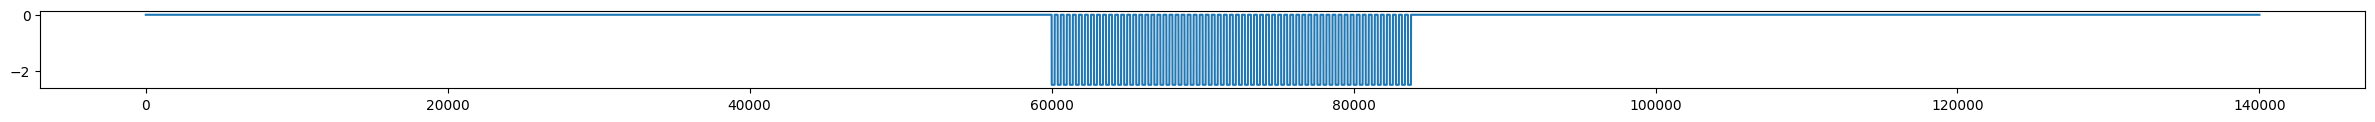

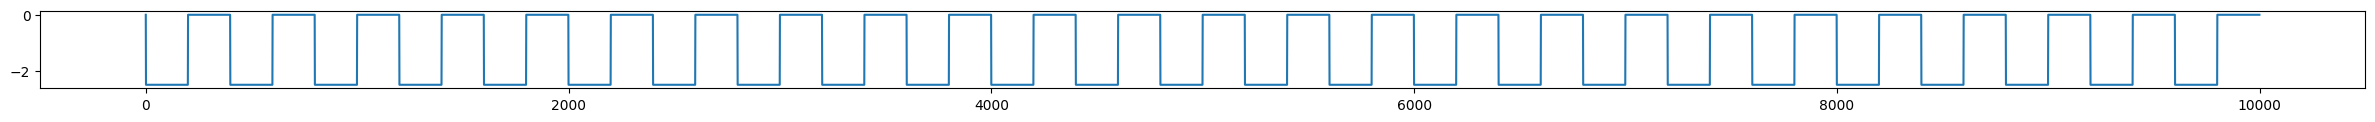

In [57]:
dt = 0.05
onset = 3000 # ms
stim_length = onset + 1200 # stimulation length (including onset) ms
simulation_length = 7000 # ms
freq = 50/1000 # frequency converted to 1/ms
T = 1/freq # pulse repetition period [ms]
tau = 10 # pulse width [ms]
I = 2.5 # intensity [mA]

# Temporal stimulation pattern
class vector1D(equations.DiscreteEquation):
    equation = equations.Final(default="emp")
eqn_t = vector1D()
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse1_ts = [p[1] for p in pulse1]
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse2_ts = [p[1] for p in pulse2]
pulse_ts = -np.asarray(pulse1_ts) #- np.asarray(pulse2_ts)
stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)

print("Stimuli applied from the SEEG electrode")
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts)
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts[60000:70000])
plt.show()

In [58]:
# Spatial stimulation pattern (via weights accross the network nodes)
stim_weight = 3
stim_weights = np.zeros((nb_regions))
stim_weights[idx_EZ] = np.array([stim_weight])
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=con,
                                  weight=stim_weights)
stimulus.configure_space()
stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

In [59]:
# Initial conditions
init_cond = np.array([-1.98742113e+00 , -1.87492138e+01, 4.0529597e+00, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

# Coupling
coupl = coupling.Difference(a=np.array([-0.2]))

#Integrator
hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.1, noise=hiss)

# Monitors
rm = region_mapping.RegionMapping.from_file()
mon_tavg = monitors.TemporalAverage(period=1.)
mon_EEG = monitors.EEG.from_file()
mon_EEG.region_mapping=rm
mon_EEG.period=1. 
rec = (mon_tavg, mon_EEG)

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=rec)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
(ttavg, tavg), (teeg, eeg) = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 72.8821930885315


Text(0.5, 1.0, 'EEG')

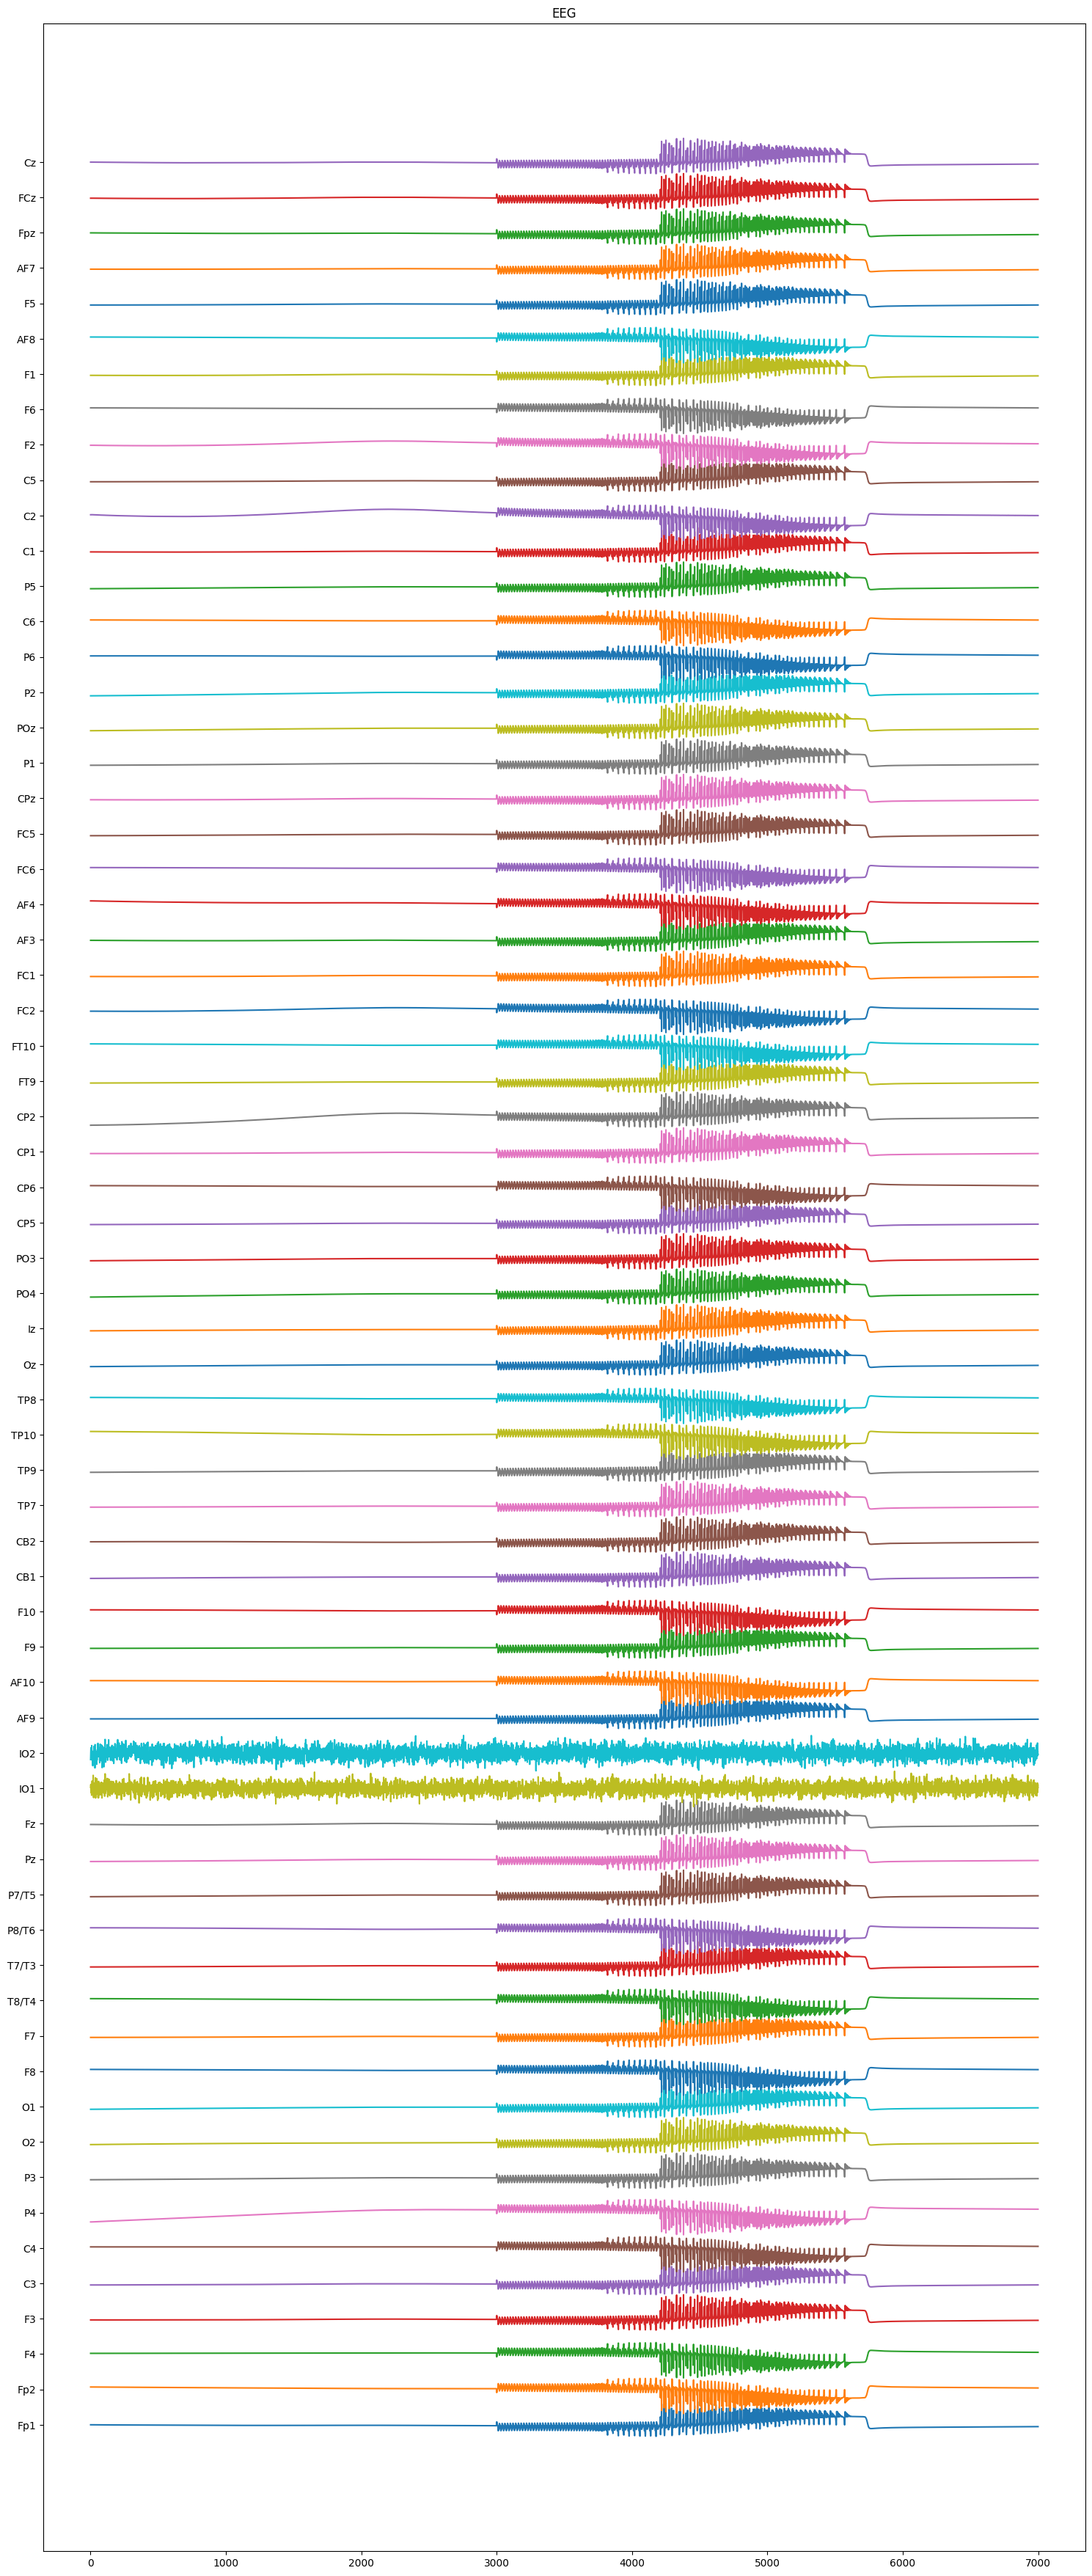

In [61]:
eeg /= (np.max(eeg,0) - np.min(eeg,0 ))
eeg -= np.mean(eeg, 0)

fig = plt.figure(figsize=(15,35))
plt.plot(teeg[:], eeg[:, 0, :, 0] + np.r_[:65])
plt.yticks(np.r_[:65], mon_EEG.sensors.labels)
fig.tight_layout()
plt.title("EEG")

## Applying the MEST 

In [60]:
x0ez=-2.1+(0.37*-2.1)
x0pz=-2.12+(0.37*-2.12)
x0num=-2.4+(0.37*-2.4)

#Here I set the x0 emulating a temporal sclerosis, which is worse in in the anterior right hippocampus but also made 
#damage to nearby areas, as showed in common MRI findings (https://radiopaedia.org/articles/1664)
EZ = ['Right-Hippocampus-anterior']
PZ = ['Right-Hippocampus-posterior', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Amygdala', 'Right-T3-anterior', 
      'Right-Posterior-cingulate-cortex-dorsal', 'Right-Posterior-cingulate-cortex-retrosplenial-gyrus']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.02

# Initial conditions
init_cond = np.array([-1.98742113e+00 , -1.87492138e+01, 4.0529597e+00, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

#Integrator
heunint = integrators.HeunDeterministic(dt=0.05)

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 125.53569149971008


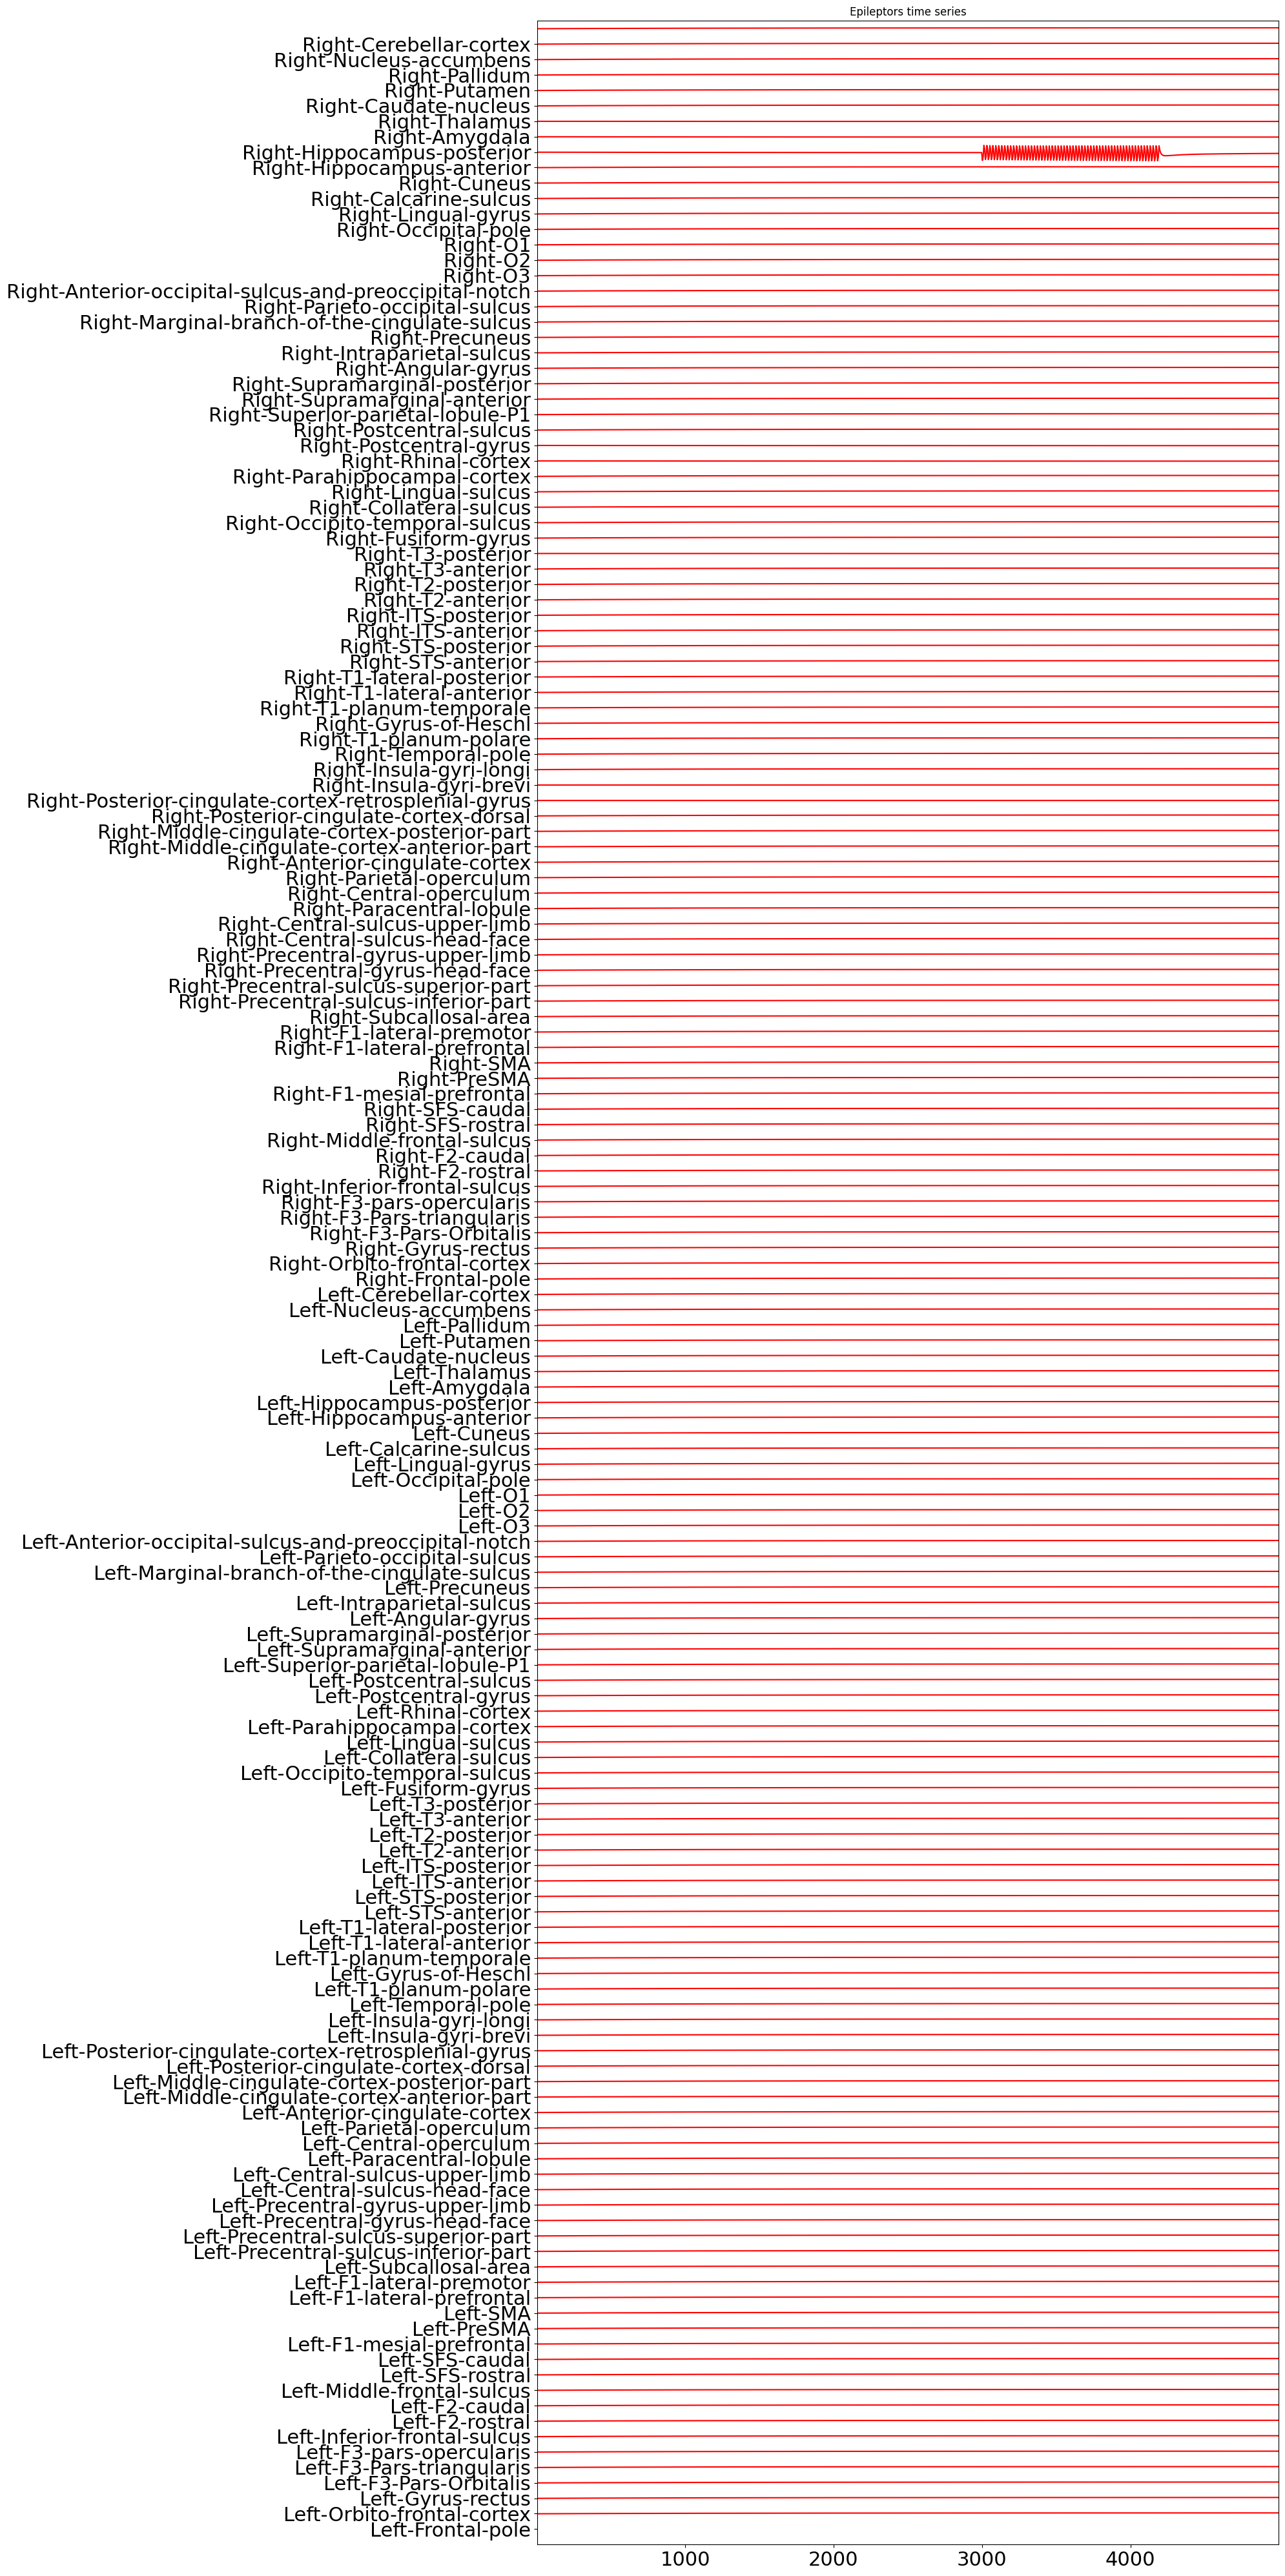

In [61]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()

In [62]:
seeg_xyz_file = f'{data_path}/seeg.xyz'
seeg_xyz = []
seeg_xyz_names = []

with open(seeg_xyz_file, 'r') as cf:
    for line in cf.readlines():
        name, *sxyz = line.strip().split()
        xyz = [float(_) for _ in sxyz]
        seeg_xyz.append((name, xyz))
        seeg_xyz_names.append(name)
        
inv_gain_file = f'{data_path}/gain_inv-square.vep.txt'
invgain = np.loadtxt(inv_gain_file)

gain, bip_xyz, bip_names = bipolarize_gain_minus(invgain, seeg_xyz, seeg_xyz_names) #funzione per fare cose sui gain (boh vabe)
gain_inv_prior, _, _ =  bipolarize_gain_minus(invgain, seeg_xyz, seeg_xyz_names, is_minus=False)

seeg = np.dot(gain, srcSig.T)

sfreq = 250.
nch = np.r_[:len(bip_names)]
nch_source = []
for chan_index, chan in enumerate(bip_names):
    source = roi[np.argmax(gain_inv_prior[chan_index])]
    nch_source.append(f'{source}:{chan}')

Text(0.5, 1.0, 'SEEG timeseries')

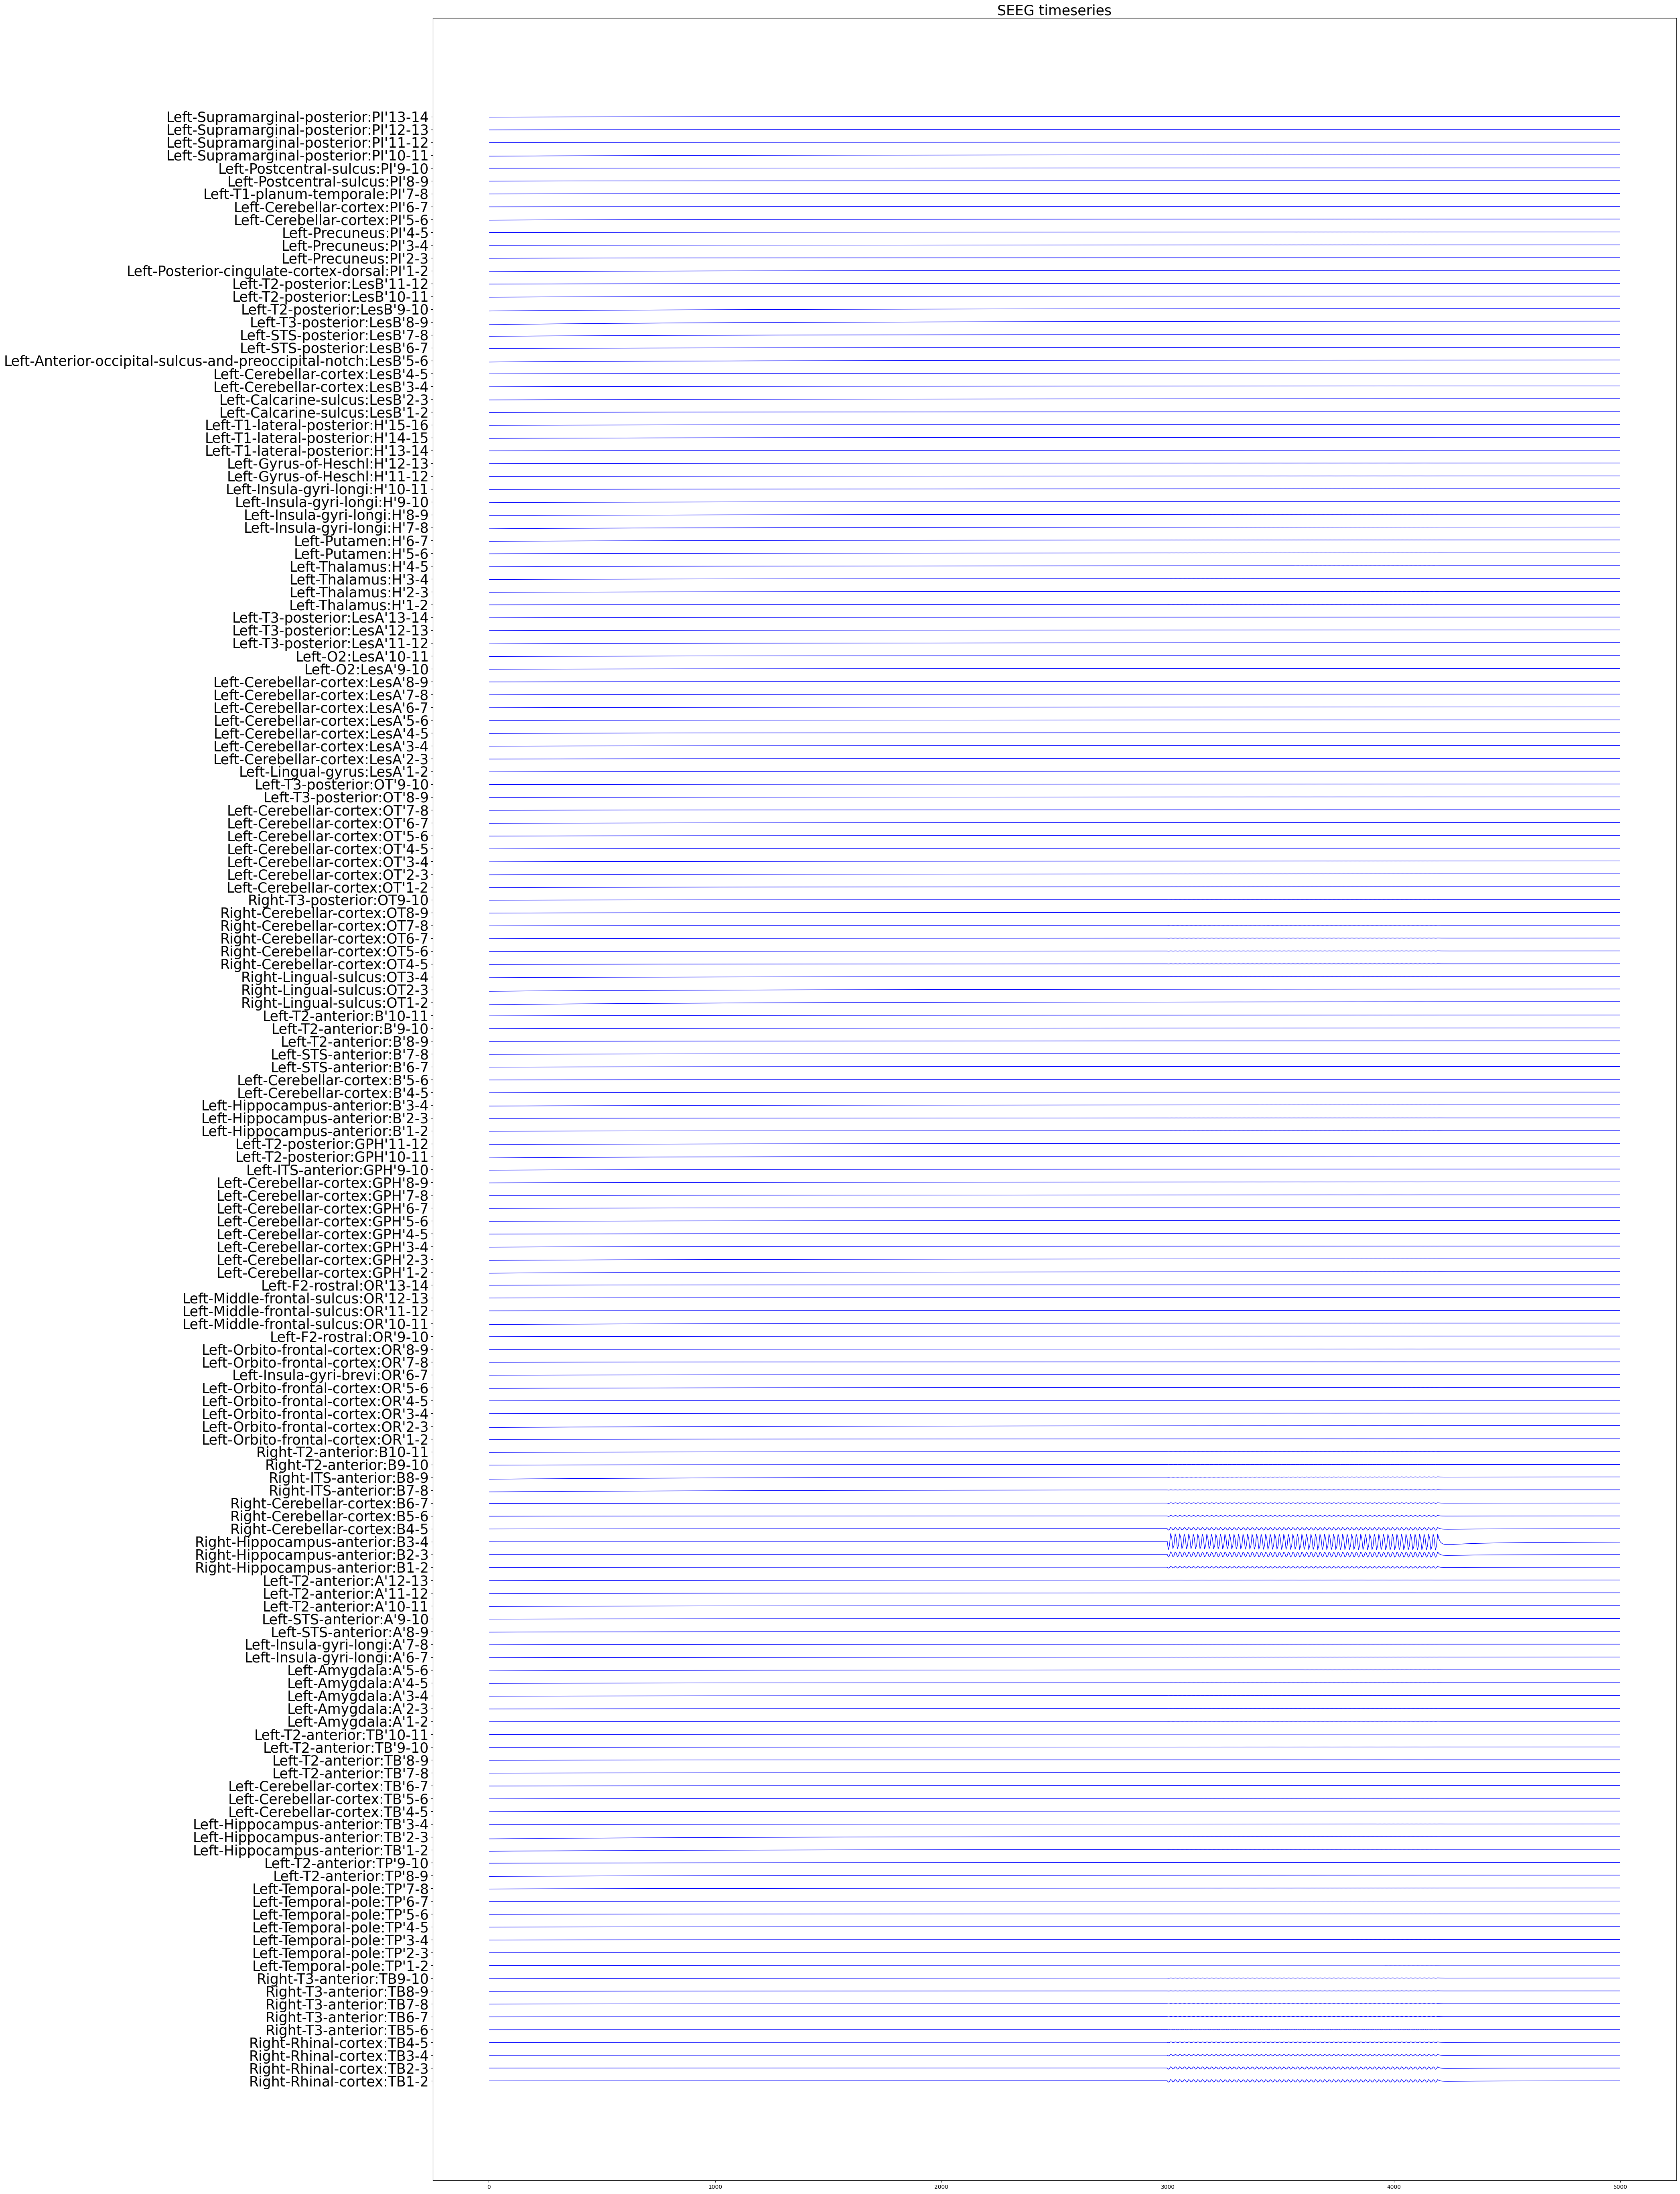

In [63]:
plt.figure(figsize=[40,70])
scaleplt = 0.07
for ind, ich in enumerate(nch):
    plt.plot(tts[:], scaleplt*(seeg[ich,:]-seeg[ich].mean()) + ind, 'b', lw=1) #linewidth
    
plt.yticks(np.arange(len(bip_names)), nch_source, fontsize= 25)
plt.title('SEEG timeseries', fontsize=25)

In [64]:
right_nch = []
for rig, reg in enumerate(nch_source):
    if 'Right' in reg:
        right_nch.append(rig)
right_nch = np.array(right_nch)

In [65]:
right_nch_source = []
for chan_index in right_nch:
    source = roi[np.argmax(gain_inv_prior[chan_index])]
    right_nch_source.append(f'{source}')
right_nch_source

['Right-Rhinal-cortex',
 'Right-Rhinal-cortex',
 'Right-Rhinal-cortex',
 'Right-Rhinal-cortex',
 'Right-T3-anterior',
 'Right-T3-anterior',
 'Right-T3-anterior',
 'Right-T3-anterior',
 'Right-T3-anterior',
 'Right-Hippocampus-anterior',
 'Right-Hippocampus-anterior',
 'Right-Hippocampus-anterior',
 'Right-Cerebellar-cortex',
 'Right-Cerebellar-cortex',
 'Right-Cerebellar-cortex',
 'Right-ITS-anterior',
 'Right-ITS-anterior',
 'Right-T2-anterior',
 'Right-T2-anterior',
 'Right-Lingual-sulcus',
 'Right-Lingual-sulcus',
 'Right-Lingual-sulcus',
 'Right-Cerebellar-cortex',
 'Right-Cerebellar-cortex',
 'Right-Cerebellar-cortex',
 'Right-Cerebellar-cortex',
 'Right-Cerebellar-cortex',
 'Right-T3-posterior']

Text(0.5, 1.0, 'SEEG timeseries')

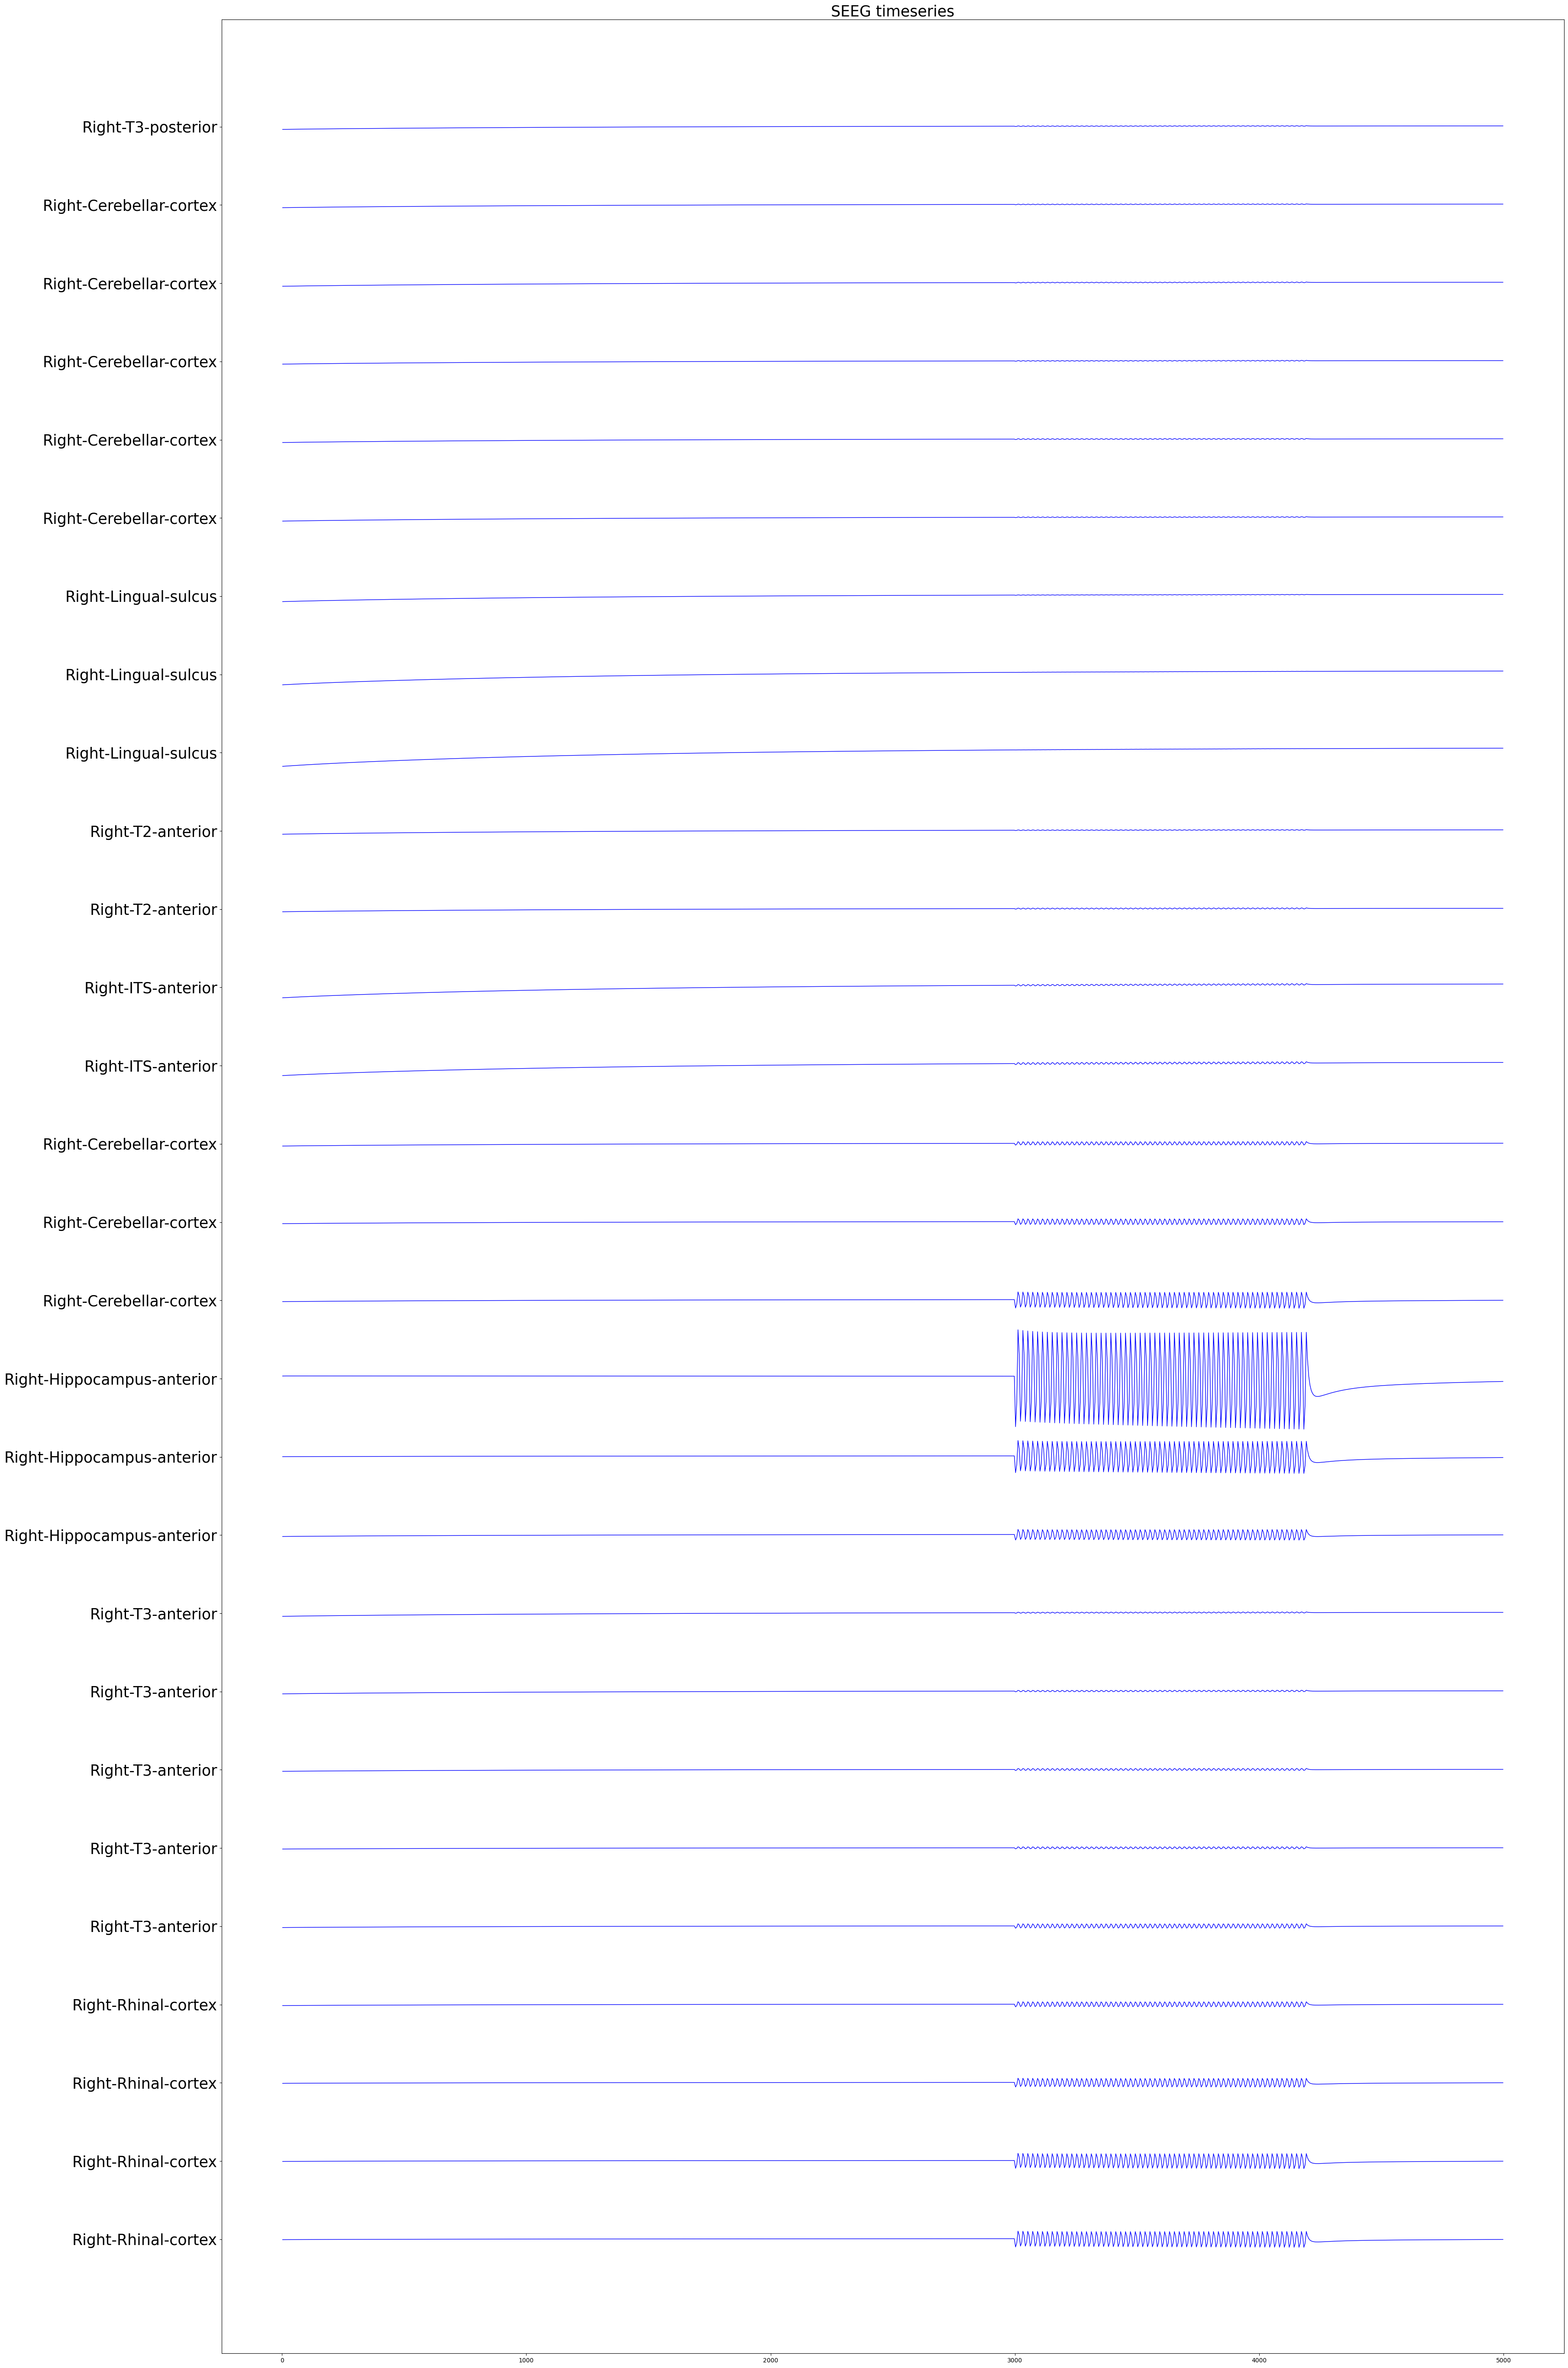

In [66]:
plt.figure(figsize=[40,70])
scaleplt = 0.07
for ind, ich in enumerate(right_nch):
    plt.plot(tts[:], scaleplt*(seeg[ich,:]-seeg[ich].mean()) + ind, 'b', lw=1) #linewidth
    
plt.yticks(np.arange(len(right_nch)), right_nch_source, fontsize= 25)
plt.title('SEEG timeseries', fontsize=25)